# Invoke Document to JSON multi-modal model

This notebook demonstrates how to process documents using a deployed SageMaker endpoint. It shows how to:

1. Load and process images
2. Make requests to a SageMaker endpoint
3. Handle responses and extract information

## Prerequisites

Before running this notebook, ensure you have:

- AWS credentials configured
- Deployed a model to a SageMaker endpoint [02_deploy_model_endpoint_vllm.ipynb](./02_deploy_model_endpoint_vllm.ipynb)
- Access to the document images

## Setup

First, let's install and import the required modules.

In [1]:
%pip install --quiet boto3 json2table

Note: you may need to restart the kernel to use updated packages.


In [58]:
import json
from pathlib import Path
from IPython.display import display, JSON, Image as IPImage, HTML, Markdown
from typing import Dict, Optional, Any, Union
import boto3
from PIL import Image
import io
import base64
from json2table import convert
from utils.helpers import get_pil_image,image_formatter

## Helpers
The following helper functions will help to process the input, output and invoke the endpoint. 

In [67]:
def process_content(response: Dict, content_type: str = "json") -> str:
    """
    Process the response content based on type.
    
    Args:
        response: The API response dictionary
        content_type: Type of content to process ("json" or "markdown")
    Returns:
        Processed HTML content as string
    """
    content = response.get("choices", [{}])[0].get("message", {}).get("content")
    
    if not content:
        return "No content found in response"
        
    try:
        if content_type.lower() == "json":
            json_content = json.loads(content)
            return convert(
                json_content,
                table_attributes={"class": "table table-striped"}
            )
        elif content_type.lower() == "markdown":
            return markdown.markdown(content)
        else:
            return f"Unsupported content type: {content_type}"
    except Exception as e:
        return f"Error processing {content_type}: {str(e)}"
        
def display_results(image_path: str, response: Dict, format_type: str = "html") -> None:
    """
    Display input image and extracted information side by side.
    
    Args:
        image_path: Path to the input image
        response: Processed response from the endpoint
        format_type: Type of format to display ("html" or "markdown")
    """
    # Get content from response
    content = response.get("choices", [{}])[0].get("message", {}).get("content", "")
    
    if format_type == "html":
        # For HTML format
        try:
            # Try to parse as JSON first
            json_content = json.loads(content)
            formatted_content = convert(
                json_content, 
                table_attributes={"class": "table table-striped"}
            )
        except json.JSONDecodeError:
            # If not JSON, use content as is
            formatted_content = content
            
        img_html = image_formatter(get_pil_image(image_path))
        
        html = f"""
        <div style="font-size: 24px; font-weight: bold; text-align: center; margin-bottom: 20px;">Invoice Details</div>
        <div style="display: flex; gap: 0px; align-items: flex-start;">
            <!-- Image Section -->
            <div style="flex: 1; text-align: center;">
                {img_html}
            </div>
        
            <!-- Content Section -->
            <div style="flex: 1; overflow-x: auto;">
               {formatted_content}
            </div>
        </div>
        """
        
        display(HTML(html))
        
    elif format_type == "markdown":
        # For Markdown format
        # First display the image
        img_html = image_formatter(get_pil_image(image_path))
        display(HTML(f'<div style="text-align: center;">{img_html}</div>'))
        
        # Then display the markdown content
        if content.startswith("```markdown"):
            # Remove markdown code block wrapper if present
            content = content.replace("```markdown", "").replace("```", "").strip()
        
        display(Markdown(content))
    
    else:
        raise ValueError("format_type must be either 'html' or 'markdown'")

In [68]:
def encode_image(image_path: Union[str, Path]) -> str:
    """
    Convert image to base64 string with proper MIME type prefix.
    
    Args:
        image_path: Path to the image file
        
    Returns:
        Base64 encoded image string with data URI prefix
        
    """
    try:
        with Image.open(image_path) as image:
            buffered = io.BytesIO()
            image.save(buffered, format=image.format)
            mime_type = Image.MIME[image.format]
            img_str = f"data:{mime_type};base64,{base64.b64encode(buffered.getvalue()).decode()}"
            return img_str
    except Exception as e:
        print(f"Error loading image: {str(e)}")
        return None

In [69]:
def load_schema(schema_path: Optional[str]) -> Dict[str, Any]:
    """
    Load JSON schema from file.

    Args:
        schema_path: Path to the json schema file
    
    Returns:
        Loaded JSON schema
    """
    if schema_path:
        try:
            with open(schema_path, 'r') as f:
                json_schema = json.load(f)
                return json_schema
            print("Schema loaded successfully")
        except Exception as e:
            print(f"Error loading schema: {str(e)}")
    
    return None

## Configuration
Replace the values below.

In [70]:
ENDPOINT_NAME = "vllm-sagemaker-qwen" # Replace with your endpoint name
MODEL_NAME = "Qwen/Qwen2.5-VL-3B-Instruct" # Replace with vllm served model name if you changed it
IMAGE_PATH = "./images/test_invoice_0_1.jpg" # Replace with image path

## Example 1: Structured Output
The following is an example of structured output using the guided_json output format option in vLLM which ensures that the model generates a structures JSON response.

In [71]:
def prepare_payload(model_name: str, image_base64: Optional[str], properties_to_extract: str = "", guided_decoding = None) -> Dict[str, Any]:
    """
    Prepare the request payload.
    
    Args:
        model_name: the model to invoke
        image_base64: Optional Base64 encoded image
        properties_to_extract: Optional JSON key names to extract. 
                                They will be added to prompt.
        schema: Optional vllm structured output configuration 
        
    Returns:
        Request payload dictionary
    """
    content = []

    content.append({
        "type": "text",
        "text": "Document pages: "
    })
    
    if image_base64:
        content.append({
            "type": "image_url",
            "image_url": {"url":image_base64}
        })

    
    content.append({
        "type": "text",
        "text": f"Process all document pages and extract the following information in JSON format: {properties_to_extract}"
    })
    
    
    payload = {
        "model": model_name,
        "messages": [
            {
                "role": "system", 
                "content": "You are a document processing expert and assistant."
            },
            {
                "role": "user",
                "content": content
            }
        ],
        "extra_body": guided_decoding
    }

    if schema:
         payload["guided_json"] = schema

    return payload    

In [72]:
def invoke_endpoint(endpoint_name: str, payload: Dict[str, Any]) -> Dict[str, Any]:
    """
    Process a document using the SageMaker endpoint.
    
    Args:
        endpoint_name: name of the SageMaker endpoint
        payload: the input to send to the endpoint
        
    Returns:
        Processed document data
    """
    runtime = boto3.client('sagemaker-runtime')
    

    print(f"Invoking {endpoint_name}")
    # Invoke endpoint
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=json.dumps(payload)
    )
    
    # Parse response
    response_body = json.loads(response['Body'].read().decode())
    return response_body
            

Here we are using structured output / constrained decoding to guide the models response structure, for example to only allow valid JSON:

In [73]:
SCHEMA_PATH = "./data/structured_output.json" # optional replace with json schema file of expected output format

### Prepare Input

In [74]:
if SCHEMA_PATH:
     schema = load_schema(SCHEMA_PATH)
     guided_decoding =  {"guided_json": schema}
     properties_to_extract = ", ".join(schema.get("required", []))

In [75]:
image_base64 = encode_image(IMAGE_PATH)
    
payload = prepare_payload(MODEL_NAME, image_base64, properties_to_extract, guided_decoding)

In [76]:
from IPython.display import JSON
JSON(payload)

<IPython.core.display.JSON object>

### Invoke Endpoint

In [77]:
response = invoke_endpoint(ENDPOINT_NAME, payload)

Invoking vllm-sagemaker-qwen


Next, let's look at the raw response.

### Inspect Response

In [78]:
JSON(response, expanded=True)

<IPython.core.display.JSON object>

Next, let's show the image of the document and the extracted JSON side by side:

DATE,2022-01-14
NUMBER,5331
SELLER_NAME,Thomas Johnson DDS
TOTAL,$493.2

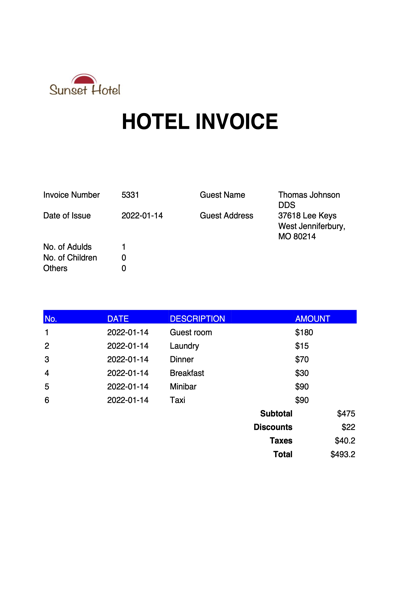

In [79]:
display_results(IMAGE_PATH, response)

## Example 2: Output in Markdown format
The following is an example of output in markdown format

In [80]:
def prepare_payload(model_name: str, image_base64: Optional[str]) -> Dict[str, Any]:
    """
    Prepare the request payload.
    
    Args:
        model_name: the model to invoke
        image_base64: Optional Base64 encoded image
        
    Returns:
        Request payload dictionary
    """
    content = []

    content.append({
        "type": "text",
        "text": "Document pages: "
    })
    
    if image_base64:
        content.append({
            "type": "image_url",
            "image_url": {"url": image_base64}
        })

    content.append({
        "type": "text",
        "text": f"Process all document pages and extract all the invoice details in markdown format. Only return the final response in markdown format."
    })
    
    payload = {
        "model": model_name,
        "messages": [
            {
                "role": "system", 
                "content": "You are a document processing expert and assistant."
            },
            {
                "role": "user",
                "content": content
            }
        ]
    }

    return payload

In [81]:
def invoke_endpoint(endpoint_name: str, payload: Dict[str, Any]) -> Dict[str, Any]:
    """
    Process a document using the SageMaker endpoint.
    
    Args:
        endpoint_name: name of the SageMaker endpoint
        payload: the input to send to the endpoint
        
    Returns:
        Processed document data
    """
    runtime = boto3.client('sagemaker-runtime')
    

    print(f"Invoking {endpoint_name}")
    # Invoke endpoint
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='application/json',
        Body=json.dumps(payload)
    )
    
    # Parse response
    response_body = json.loads(response['Body'].read().decode())
    return response_body

### Prepare Input

In [82]:
image_base64 = encode_image(IMAGE_PATH)
    
payload = prepare_payload(MODEL_NAME, image_base64)

In [83]:
from IPython.display import JSON
JSON(payload)

<IPython.core.display.JSON object>

### Invoke Endpoint

In [84]:
response = invoke_endpoint(ENDPOINT_NAME, payload)

Invoking vllm-sagemaker-qwen


### Inspect Response
Now, let's look at the raw response

In [85]:
JSON(response, expanded=True)

<IPython.core.display.JSON object>

Next, let's show the image of the document and the extrated JSON side by side


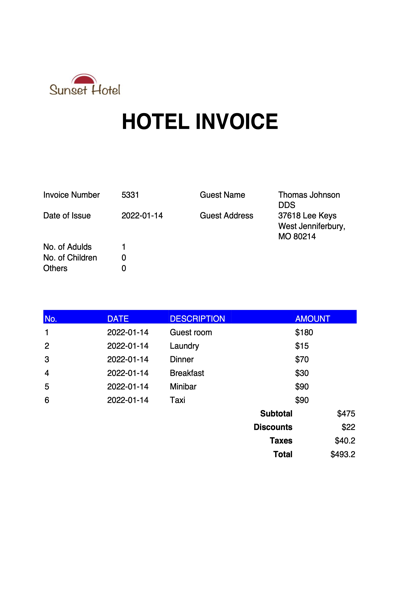

# Hotel Invoice

## Invoice Details
- **Invoice Number:** 5331
- **Date of Issue:** 2022-01-14
- **Guest Name:** Thomas Johnson DDS
- **Guest Address:** 37618 Lee Keys West Jenniferbury, MO 80214
- **No. of Adults:** 1
- **No. of Children:** 0
- **Others:** 0

## Invoice Items
| No. | DATE       | DESCRIPTION                | AMOUNT |
|-----|------------|----------------------------|--------|
| 1   | 2022-01-14 | Guest room                 | $180   |
| 2   | 2022-01-14 | Laundry                    | $15    |
| 3   | 2022-01-14 | Dinner                     | $70    |
| 4   | 2022-01-14 | Breakfast                  | $30    |
| 5   | 2022-01-14 | Minibar                    | $90    |
| 6   | 2022-01-14 | Taxi                       | $90    |

## Subtotal
$475

## Discounts
$22

## Taxes
$40.2

## Total
$493.2

In [86]:
display_results(IMAGE_PATH, response, format_type="markdown")

## Conclusion

We received a structured JSON output and markdown format from the moodel and deployed endpoint by sending the image of a document and the desired target schema/instructions.